In [5]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import ROOT as r
import rootnotes
import numpy as np
import matplotlib.pyplot as plt
from rootpy.io import root_open
import rootpy.plotting.root2matplotlib as rplt

canvas = rootnotes.default_canvas()

colors = ['#348ABD', '#A60628']

# Use the Bayesian Methods for Hackers style
plt.style.use('bmh')

In [6]:
# Path to ROOT file that will be used to obtain the Trident invariant mass histogram
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass3/mc_1pt05/tridents/all/trident_analysis.root"

# Open the ROOT file and get the Trident invariant mass histogram
root_file = root_open(file_path)

## Trident Invariant Mass

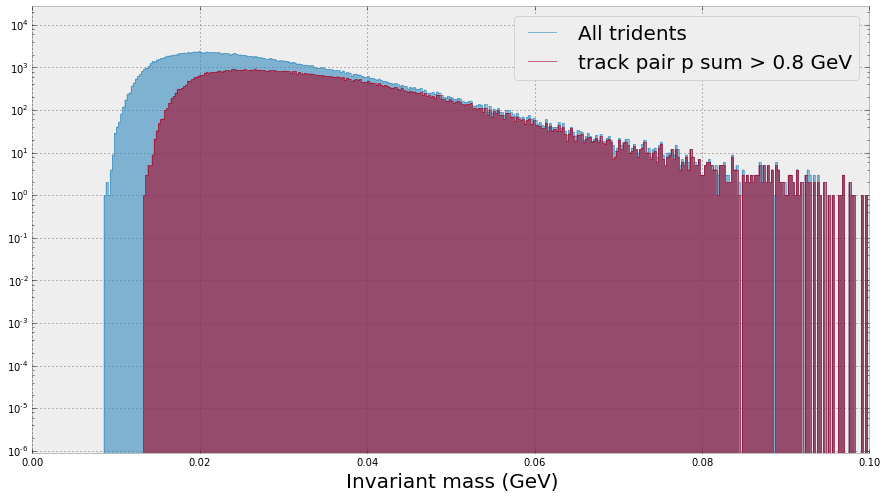

In [7]:
labels = ['All tridents', 'track pair p sum > 0.8 GeV']

histos = []
histos.append(root_file.Get('invariant mass'))
histos.append(root_file.Get('invariant mass - final'))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ax.set_xlabel("Invariant mass (GeV)", fontsize=20)
ax.set_yscale('log')

for histo_n in range(0, len(histos)) : 
    histos[histo_n].linecolor = colors[histo_n]
    histos[histo_n].fillstyle = 'solid'
    histos[histo_n].fillcolor = colors[histo_n]
    rplt.hist(histos[histo_n], axes=ax, alpha=.6, label=labels[histo_n])
    
ax.legend(fontsize=20);

## Fitting the Trident invariant mass distribution

In [34]:
# Get the Trident invariant mass histogram from the file
histo = root_file.Get("invariant mass")

canvas.Clear()

# Start by normalizing the distribution to 1.  This is required so the RooFit 
# fit actually works
histo.Sumw2()
histo.Scale(1/histo.Integral())

# Create a data histogram that is compatible with RooFit
invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.005, 0.1)
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, histo)

# Variables used to define polynomials
a = []

a.append(r.RooRealVar("t1", "t1", 0, -10, 10))
a.append(r.RooRealVar("t2", "t2", 0, -10, 10))
a.append(r.RooRealVar("t3", "t3", 0, -10, 10))
a.append(r.RooRealVar("t4", "t4", 0, -10, 10))
a.append(r.RooRealVar("t5", "t5", 0, -10, 10))
a.append(r.RooRealVar("t6", "t6", 0, -10, 10))
a.append(r.RooRealVar("t7", "t7", 0, -10, 10))
#a.append(r.RooRealVar("t8", "t8", 0, -100, 100))
#a.append(r.RooRealVar("t9", "t9", 0, -100, 100))

arg_list = r.RooArgList()

for a_val in a : arg_list.add(a_val)

invariant_mass.setRange("full_range", 0.012, 0.085)
    
#model = r.RooPolynomial("model", "model", invariant_mass,  arg_list)
model = r.RooChebychev("model", "model", invariant_mass,  arg_list)

model.fitTo(histogram_data, r.RooFit.Range("full_range"))

# Get the frame that will be used in plotting
plot = invariant_mass.frame()

# Plot the histogram data
histogram_data.plotOn(plot)
model.plotOn(plot)

# Draw the frame 
plot.Draw()
plot.SetTitle("")
canvas.SetLogy()
canvas

ERROR:ROOT.THistPainter.PaintInit:log scale requested with a negative argument (-0.000636)
ERROR:ROOT.THistPainter.PaintInit:log scale requested with a negative argument (-0.000636)


ROOTError: level=3000, loc='THistPainter::PaintInit', msg='log scale requested with a negative argument (-0.000636)'

<ROOT.TCanvas object ("icanvas") at 0x4e1b0a0>

# Composite Model

The trident invariant mass distribution will be searched for a resonance by doing a maximum likelihood fit using the following composite model

$M(x) = N_{S}S(x) + N_BB(x)$

Here, $S(x)$ is a gaussian pdf with a mass set to the hypothesized $A'$ mass and the width set to the measured mass resolution.  The background, $B(x)$ will be described using a, to be determined, polynomial.


In [55]:
invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.005, 1.0)
#invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.03, 0.04)

#
# Signal PDF
#

# The mean of the signal must be set and can't vary
ap_mass_mean = r.RooRealVar("ap_mass_mean", "ap_mass_mean", .03)
ap_mass_mean.setConstant(r.kTRUE)

# For now, assume a constant mass resolution across our range
ap_mass_sigma = r.RooRealVar("ap_mass_sigma", "ap_mass_sigma", 0.003)
ap_mass_sigma.setConstant(r.kTRUE)

# Create a gaussian signal pdf with the mean at the mass hypothesis and sigma
# set to the mass resolution
signal = r.RooGaussian("signal", "signal", invariant_mass, ap_mass_mean, ap_mass_sigma)

#
# Background PDF's
#

# Variables used to define polynomials
a = []

a.append(r.RooRealVar("t1", "t1", 0, -10, 10))
a.append(r.RooRealVar("t2", "t2", 0, -10, 10))
a.append(r.RooRealVar("t3", "t3", 0, -10, 10))
a.append(r.RooRealVar("t4", "t4", 0, -10, 10))
a.append(r.RooRealVar("t5", "t5", 0, -10, 10))
a.append(r.RooRealVar("t6", "t6", 0, -10, 10))
a.append(r.RooRealVar("t7", "t7", 0, -10, 10))

bkg_models = []
arg_list = r.RooArgList()
for var_index in range(0, len(a)) :
    arg_list.add(a[var_index])
    bkg_models.append(r.RooChebychev("bkg_" + str(var_index), 
                                     "bkg_" + str(var_index), 
                                     invariant_mass, 
                                     arg_list)) 
    
# Number of events
nsig = r.RooRealVar("nsig","signal fraction", 0, -800, 800)
nbkg = r.RooRealVar("nbkg","background fraction", 10000., 0.,100000.) 

#
# Composite model
#

comp_models = []
bkg_comp_models = []

for var_index in range(0, len(a)) :   
    comp_models.append(r.RooAddPdf("model_" + str(var_index), 
                              "model_" + str(var_index), 
                               r.RooArgList(signal, bkg_models[var_index]), 
                               r.RooArgList(nsig, nbkg)))
            
    bkg_comp_models.append(r.RooAddPdf("model_" + str(var_index), 
                              "model_" + str(var_index), 
                               r.RooArgList(bkg_models[var_index]), 
                               r.RooArgList(nbkg)))  







# Fitting multiple polynomials within a window

## Background only Fit

Expected number of background events: 26056.0
chi2/dof: 0.938625385831
chi2/dof: 0.938025265854
chi2/dof: 0.889533105561
chi2/dof: 0.891638060512
chi2/dof: 0.886836300635
chi2/dof: 0.929274821361
chi2/dof: 0.923022800695


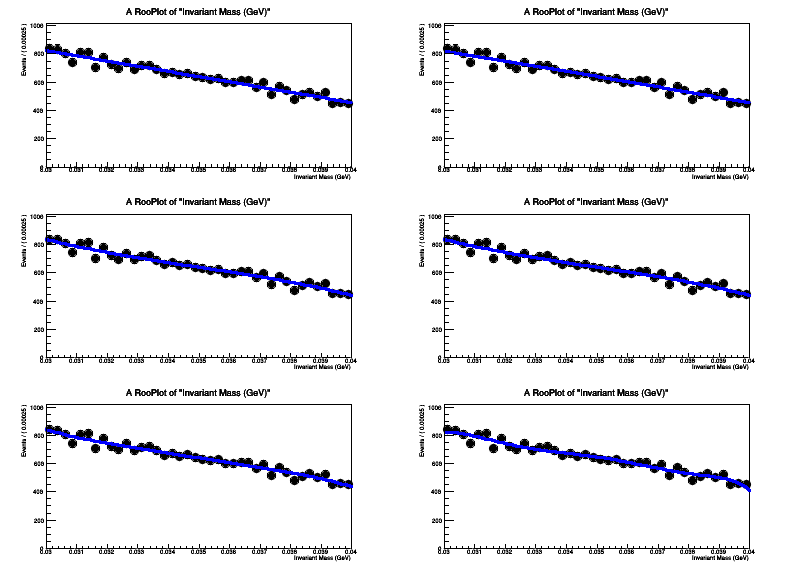

In [59]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

#for bin_n in mass_histo.bins_range() : 
#    print "Bin number : " + str(bin_n) + " :: Bin Center: " + str(mass_histo.GetXaxis().GetBinCenter(bin_n))
print "Expected number of background events: " + str(mass_histo.Integral(121, 161))

# Create a data histogram that is compatible with RooFit
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

min_val = 0.03
max_val = 0.04
invariant_mass.setRange("test_range", min_val, max_val)

canvas.Clear()
canvas.Divide(2,3)

index = 1
    
for model in bkg_comp_models : 
    
    # Plot the results
    invariant_mass.setRange(min_val, max_val)
    plot = invariant_mass.frame()
    
    
    # Fit the window to the background model
    result = model.fitTo(histogram_data,
                         r.RooFit.SumCoefRange("test_range"),
                         r.RooFit.Extended(r.kTRUE),
                         r.RooFit.Range("test_range"),
                         r.RooFit.Save())
    
    histogram_data.plotOn(plot)
    model.plotOn(plot,
                 r.RooFit.Range("test_range"), 
                 r.RooFit.NormRange("test_range"))
    
    canvas.cd(index)
    plot.Draw()
    
    # Calculate the chi^2
    print "chi2/dof: " + str(plot.chiSquare())
    
    index += 1

    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
canvas

## Composite model fit 

chi2/dof: 659.288266775
chi2/dof: 664.894366581
chi2/dof: 659.283335833
chi2/dof: 658.71500532
chi2/dof: 657.047044986
chi2/dof: 656.994424086
chi2/dof: 657.17697656


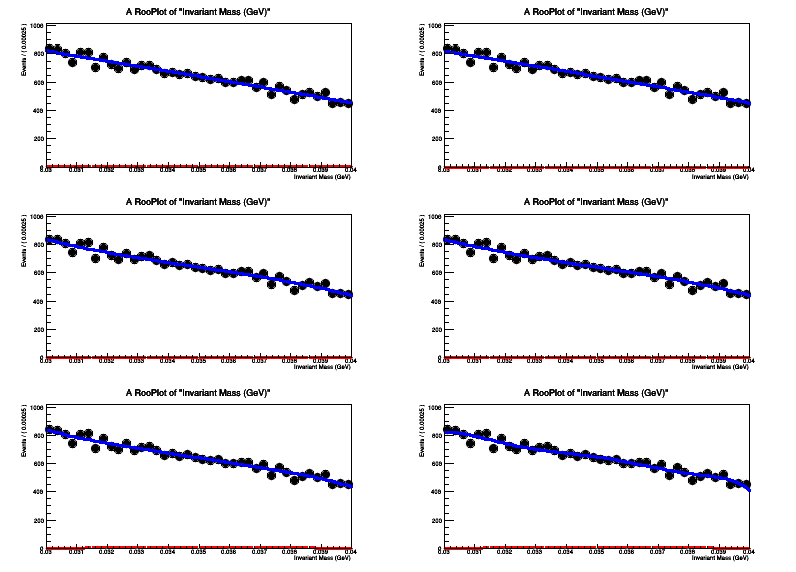

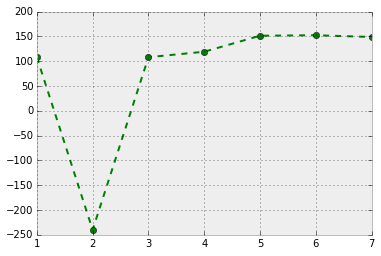

In [56]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

# Create a data histogram that is compatible with RooFit
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

min_val = 0.03
max_val = 0.04
invariant_mass.setRange("test_range", min_val, max_val)
ap_mass_mean.setVal(.035)

canvas.Clear()
canvas.Divide(2,3)

s = []
s_error = []
poly_values = []

index = 1

for model in comp_models :
    
    # Plot the results
    invariant_mass.setRange(min_val, max_val)
    plot = invariant_mass.frame()
    
    # Fit the window to the background model
    result = model.fitTo(histogram_data,
                         r.RooFit.SumCoefRange("test_range"),
                         r.RooFit.Extended(r.kTRUE),
                         r.RooFit.Range("test_range"),
                         r.RooFit.Save())
    
    histogram_data.plotOn(plot)
    model.plotOn(plot,
                 r.RooFit.Range("test_range"), 
                 r.RooFit.NormRange("test_range"))
    model.plotOn(plot, 
                 r.RooFit.Range("test_range"),
                 #r.RooFit.NormRange("test_range"), 
                 r.RooFit.Components("signal"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed),
                 r.RooFit.LineColor(r.RooFit.kRed))
    
    canvas.cd(index)
    plot.Draw()
    
    # Calculate the chi^2
    print "chi2/dof: " + str(plot.chiSquare())
    
    params = model.getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    poly_values.append(index)
    
    index += 1
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
    
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())
    
s_pull = np.divide(np.array(s), np.array(s_error))
plt.plot(poly_values, s,'g--o')
    
canvas

# Fitting Using the Model

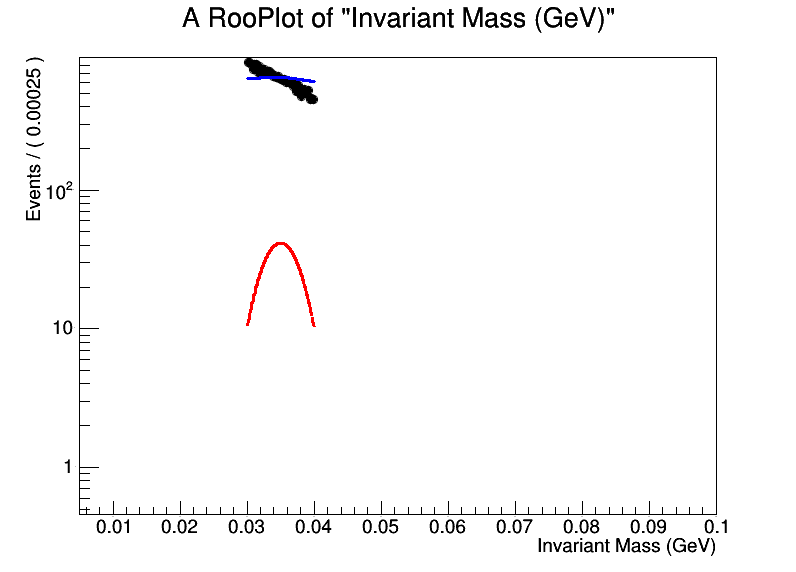

In [57]:
# Get the Trident invariant mass histogram from the file
mass_histo = histos[1].Clone()

# Create a data histogram that is compatible with RooFit
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, mass_histo)

canvas.Clear()

mass_window_size = 0.01
mass_window_step = 0.0005
mass_window_start = 0.03

invariant_mass.setRange(0.005, 0.1)

plot = invariant_mass.frame()
histogram_data.plotOn(plot)

s = []
s_error = []
mass = []

while mass_window_start <= 0.040 - mass_window_size : 
    
    #print "Fitting in window [ " + str(mass_window_start) + ", " + str(mass_window_start + mass_window_size) + " ]"
    ap_mass = mass_window_start + mass_window_size/2
    invariant_mass.setRange("A' mass = " + str(ap_mass),
                            mass_window_start,
                            mass_window_start + mass_window_size)
    invariant_mass.setRange(mass_window_start,
                            mass_window_start + mass_window_size)
    #print "Setting A' mass hypothesis to " + str(ap_mass) + " GeV"
    ap_mass_mean.setVal(ap_mass)
    mass.append(ap_mass)
    
    result = comp_models[6].fitTo(histogram_data,
                         r.RooFit.SumCoefRange("A' mass = " + str(ap_mass)),
                         r.RooFit.Extended(r.kTRUE),
                         r.RooFit.Range("A' mass = " + str(ap_mass)),
                         r.RooFit.Save())
    
    comp_models[6].plotOn(plot,
                     r.RooFit.Range("A' mass = " + str(ap_mass)),
                     r.RooFit.NormRange("A' mass = " + str(ap_mass)))
    
    comp_models[6].plotOn(plot,
                     r.RooFit.Range("A' mass = " + str(ap_mass)),
                     r.RooFit.Components("signal"),
                     r.RooFit.LineStyle(r.RooFit.kDashed), 
                     r.RooFit.NormRange("A' mass = " + str(ap_mass)),
                     r.RooFit.LineColor(r.RooFit.kRed))
    
    params = comp_models[6].getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    mass_window_start += mass_window_step
    
    # Reset all of the parameters
    initial_params = result.floatParsInit()
    
    for a_var in a : 
        
        #print "Resetting value of " + str(a_var.GetName())
        #print "Current value: " + str(a_var.getVal()) + " Current Error: " + str(a_var.getError())
        
        if initial_params.index(a_var.GetName()) == -1 : 
            #print "Variable is not in argument list."
            continue 
        a_var.setVal(initial_params[initial_params.index(a_var.GetName())].getVal())
        a_var.setError(initial_params[initial_params.index(a_var.GetName())].getError())
        
        #print "Reset value: " + str(a_var.getVal()) + " Reset Error: " + str(a_var.getError())
        
    nsig.setVal(initial_params[initial_params.index(nsig.GetName())].getVal())
    nsig.setError(initial_params[initial_params.index(nsig.GetName())].getError())
    nbkg.setVal(initial_params[initial_params.index(nbkg.GetName())].getVal())
    nbkg.setError(initial_params[initial_params.index(nbkg.GetName())].getError())

canvas.SetLogy()
plot.Draw()
canvas

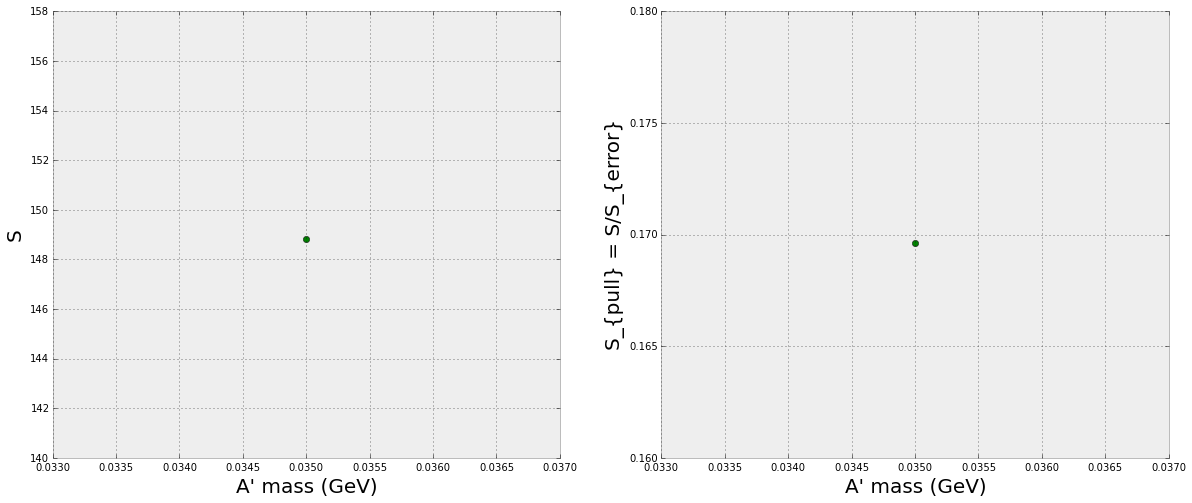

In [58]:
s_pull = np.divide(np.array(s), np.array(s_error))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))

ax0.plot(mass, s, 'g--o')
ax0.set_xlabel("A' mass (GeV)", fontsize=20)
ax0.set_ylabel("S", fontsize=20)
ax1.plot(mass, s_pull, 'g--o')
ax1.set_xlabel("A' mass (GeV)", fontsize=20)
ax1.set_ylabel("S_{pull} = S/S_{error}", fontsize=20)